In [2]:
import os
import sys
import glob

In [3]:
in_notebooks_dir = (
    (os.path.basename(os.getcwd()) == 'notebooks') and 
    (os.path.exists(os.path.join(os.path.dirname(os.getcwd()), 'src')))
)
if in_notebooks_dir:
    os.chdir(os.path.dirname(os.getcwd()))

srcdir = os.path.join('..', 'src')
if srcdir not in sys.path:
    sys.path.insert(0, srcdir)

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader
from src.models.models import SRCNN
from src.data.datasets import SRDataset
from src.data.transforms import Pad
from src.preprocessing.torch_utils import reverse_image_standardisation
import torch
import torch.optim as optim
import torch.nn as nn
# from torchmetrics import PeakSignalNoiseRatio

In [5]:
rgb_means=(0.4206, 0.4312, 0.3818)
rgb_stds=(0.2072, 0.1763, 0.1777)

### Compose transforms

In [6]:
data_transforms = {
    'train_input': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=rgb_means, std=rgb_stds),
        Pad(desired_size=(3, 110, 110)),
    ]),
    'train_target': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=rgb_means, std=rgb_stds),
        Pad(desired_size=(3, 1100, 1100)),
    ]),
}


### Load training dataset

In [7]:
training_dataset = SRDataset(
    img_dir = f'data/raw/CGG_data/train/10x',
    target_dir = f'data/raw/CGG_data/train/gt',
    transform=data_transforms['train_input'],
    target_transform=data_transforms['train_target'] 
)

In [8]:
train_dataloader = DataLoader(training_dataset, batch_size=4, shuffle=True)

print(f'Training samples: {len(train_dataloader)}')

Training samples: 307


In [9]:
img, target = next(iter(train_dataloader))

tensor(0.4146) tensor(3.1479) tensor(-1.7118)
tensor(0.4889) tensor(0.9608) tensor(0.1059)


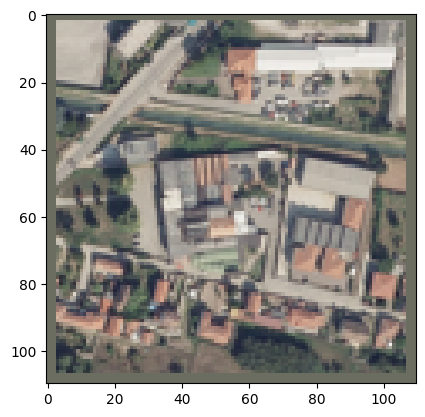

In [10]:
import matplotlib.pyplot as plt
import numpy as np

pic = img[0]
print(torch.mean(pic), torch.max(pic), torch.min(pic))
pic = reverse_image_standardisation(pic, rgb_means, rgb_stds)
print(torch.mean(pic), torch.max(pic), torch.min(pic))
plt_pic = torch.permute(pic, (2,1,0))
plt.imshow(plt_pic)

start by running tensorbord on CMD:
tensorboard --logdir=runs

then go to http://localhost:6006/

In [12]:
from torch.utils.tensorboard import SummaryWriter
import torchvision
import numpy as np

In [13]:
writer = SummaryWriter('runs/1') 

In [14]:
img_grid = torchvision.utils.make_grid(pic)
writer.add_image('images', img_grid, 0)
# writer.add_graph(model, images)
writer.close()

### Define model

In [15]:
net = SRCNN()

### Define loss function and optimizer

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

### Training on GPU/CPU

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Train the network

In [ ]:
num_epochs=2

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, targets]
        inputs, targets = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
save_path = '/simple_net.pth'
torch.save(net.state_dict(), save_path)